In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='../data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='../data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class LeNet(nn.Module):
    def __init__(self, imdim=3, num_classes=10):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(imdim, 64, kernel_size=5, stride=1, padding=0)
        self.mp = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128*5*5, 1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1024)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        in_size = x.size(0)
        out1 = self.mp(self.relu1(self.conv1(x)))
        out2 = self.mp(self.relu2(self.conv2(out1)))
        out2 = out2.view(in_size, -1)
        out3 = self.relu3(self.fc1(out2))
        out = self.relu4(self.fc2(out3))
        
        return self.fc3(out)

In [4]:
model = LeNet(num_classes=10).to(device)

In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 10, 10]         204,928
              ReLU-5          [-1, 128, 10, 10]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Linear-7                 [-1, 1024]       3,277,824
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 4,547,466
Trainable params: 4,547,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.47032     Accuracy: 46.11% 	 Test Loss: 1.20125     Test Accuracy: 57.40%
Epoch [  2/150] 	 Loss: 1.03027     Accuracy: 63.47% 	 Test Loss: 0.97433     Test Accuracy: 66.00%
Epoch [  3/150] 	 Loss: 0.82455     Accuracy: 71.00% 	 Test Loss: 0.86220     Test Accuracy: 70.42%
Epoch [  4/150] 	 Loss: 0.67546     Accuracy: 76.05% 	 Test Loss: 0.84965     Test Accuracy: 71.80%
Epoch [  5/150] 	 Loss: 0.53681     Accuracy: 81.14% 	 Test Loss: 0.84638     Test Accuracy: 71.89%
Epoch [  6/150] 	 Loss: 0.40384     Accuracy: 85.85% 	 Test Loss: 0.87175     Test Accuracy: 72.73%
Epoch [  7/150] 	 Loss: 0.28710     Accuracy: 89.90% 	 Test Loss: 0.98855     Test Accuracy: 72.31%
Epoch [  8/150] 	 Loss: 0.20728     Accuracy: 92.61% 	 Test Loss: 1.13234     Test Accuracy: 71.86%
Epoch [  9/150] 	 Loss: 0.15134     Accuracy: 94.70% 	 Test Loss: 1.31449     Test Accuracy: 72.16%
Epoch [ 10/150] 	 Loss: 0.12344     Accuracy: 95.69% 	 Test Loss: 1.37563     Test Accuracy: 72.44%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 6 with test accuracy: 72.73%


# Plot results

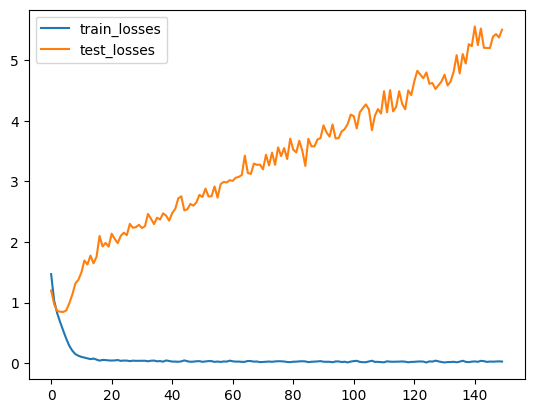

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

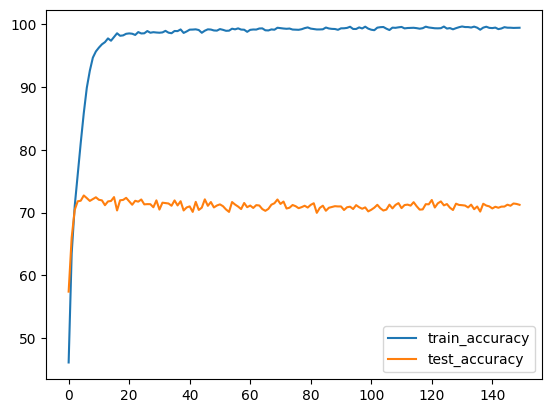

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()